Lets lurn how to

    


*   How to define and train the standalone discriminator model for learning the difference between real and fake images.

*   How to define the standalone generator model and train the composite generator and discriminator model.

*   How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.


# **MNIST Handwritten Digit Dataset**

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

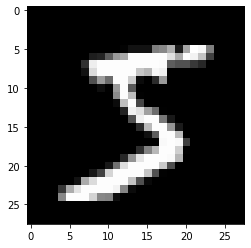

In [ ]:
plt.imshow(X_train[0], cmap='gray')

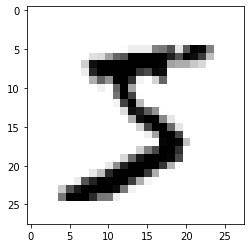

In [ ]:
# The images are grayscale with a black background (0 pixel value) and the handwritten digits in white (pixel values near 255).
#  reverse the colors and plot the background as white and the handwritten digits in black.
plt.imshow(X_train[0], cmap='gray_r')

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

Specifically, the generator model will learn how to generate new plausible handwritten digits between 0 and 9, using a discriminator that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model.

This is a relatively simple problem that does not require a sophisticated generator or discriminator model, although it does require the generation of a grayscale output image.

# **Define and Train the Discriminator Model**

---
This is a binary classification problem:

*   Inputs: Image with one channel and 28×28 pixels in size.
    
*   Outputs: Binary classification, likelihood the sample is real (or fake).




In [4]:
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
#lets create a function for the creation of the discriminator model
def define_dicriminator(in_shape=(28,28,1)):
  model = keras.Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# define model
model = define_dicriminator()
# summarize the model
# model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# plot the model
#plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# We could start training this model now with real examples with a class label of one, and randomly generated samples with a class label of zero.
# We will use the mnist.load_data() function to load the MNIST dataset and just use the input part of the training dataset as the real images.
(X_train,_ ), (_,_ ) = keras.datasets.mnist.load_data()

In [ ]:
X_train.shape

(60000, 28, 28)

In [6]:
# The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels. We must update the images to have an additional dimension for the grayscale channel
# expand to 3d, e.g. add channels dimension
X = np.expand_dims(X_train, axis=-1)

In [7]:
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [0,1]
X = X / 255.0

In [8]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(X_train, _), (_, _) = keras.datasets.mnist.load_data()
	# expand to 3d, e.g. add channels dimension
	X = np.expand_dims(X_train, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset.

The generate_real_samples() function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [9]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

Now, we need a source of fake images.

We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1] like our scaled real images.

In [10]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

Finally, we need to train the discriminator model.

This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.
The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns to discriminate perfectly.

The train_discriminator() function implements this, using a batch size of 256 images where 128 are real and 128 are fake each iteration.

In [11]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [12]:
# define the discriminator model
model = define_dicriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1 real=39% fake=18%
>2 real=47% fake=32%
>3 real=53% fake=52%
>4 real=53% fake=70%
>5 real=58% fake=78%
>6 real=51% fake=86%
>7 real=61% fake=96%
>8 real=59% fake=98%
>9 real=65% fake=100%
>10 real=62% fake=100%
>11 real=58% fake=100%
>12 real=67% fake=100%
>13 real=70% fake=100%
>14 real=68% fake=100%
>15 real=67% fake=100%
>16 real=77% fake=100%
>17 real=74% fake=100%
>18 real=85% fake=100%
>19 real=82% fake=100%
>20 real=88% fake=100%
>21 real=91% fake=100%
>22 real=91% fake=100%
>23 real=92% fake=100%
>24 real=95% fake=100%
>25 real=98% fake=100%
>26 real=94% fake=100%
>27 real=98% fake=100%
>28 real=99% fake=100%
>29 real=100% fake=100%
>30 real=98% fake=100%
>31 real=99% fake=100%
>32 real=99% fake=100%
>33 real=99% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fak

# **Define and Use the Generator Model ** 

The generator model is responsible for creating new, fake but plausible images of handwritten digits.

It does this by taking a point from the latent space as input and outputting a square grayscale image.

The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.

**Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.

**Outputs**: Two-dimensional square grayscale image of 28×28 pixels with pixel values in [0,1].
Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values.

There are a number of ways to achieve this but there is one approach that has proven effective at deep convolutional generative adversarial networks. It involves two main elements.

The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 14×14 or 196 nodes, and an image one quarter the size (one eighth the area) would be 7×7 or 49 nodes.

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.
Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

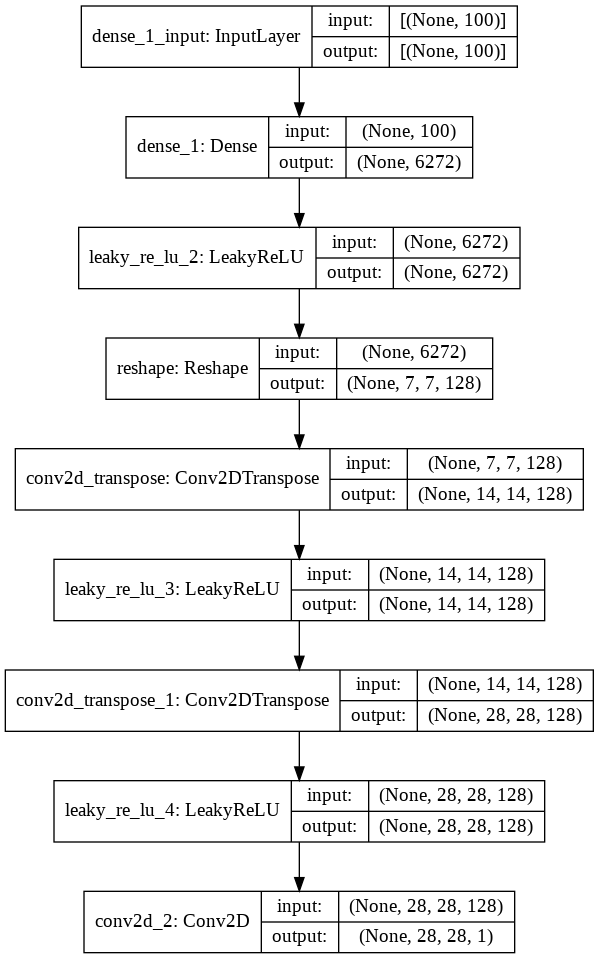

In [13]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
  # Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128.
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
  # The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7×7 feature maps.
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
  # The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions). 
  # It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

This model cannot do much at the moment.

Nevertheless, we can demonstrate how to use it to generate samples
The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The generate_latent_points() function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

We can update the generate_fake_samples() function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the generate_latent_points() function to generate the required number of points in latent space as input to the model.

In [15]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

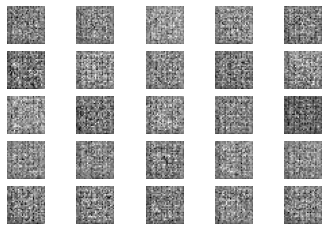

In [16]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

In [ ]:
# As the model is not trained, the generated images are completely random pixel values in [0, 1].


# **Train the Generator Model** 

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

the simplest approach is to create a new model that combines the generator and discriminator models

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models



In [23]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


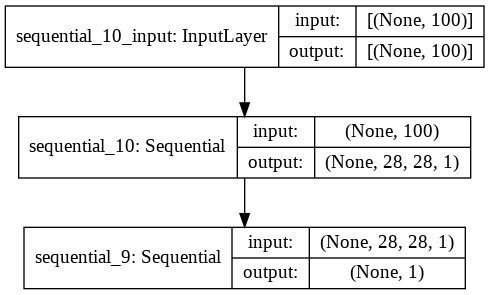

In [24]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_dicriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

This requires combining elements from the train_discriminator() function defined in the discriminator section above and the train_gan() function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples, so with rounding down, there are 234 batches per epoch.

The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the vstack() NumPy function. You could update the discriminator with each half batch separately (recommended for more complex datasets) but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [27]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

# Evaluate GAN Model Performance


In [29]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [36]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
	# evaluate the model performance, sometimes
	if(i+1) % 10 == 0 :
		summarize_performance(i, g_model, d_model, dataset, latent_dim)

IndentationError: ignored